In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import networkx as nx
from pyvis import network as net
from math import floor, ceil

In [11]:
from sklearn.datasets import make_circles

data = make_circles(n_samples=5000, noise=0.05, random_state=None, factor=0.5)

In [12]:
labels = data[1]
data = data[0]

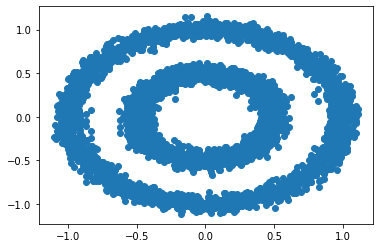

In [13]:
x = [i[0] for i in data]
y = [i[1] for i in data]

plt.scatter(x, y)

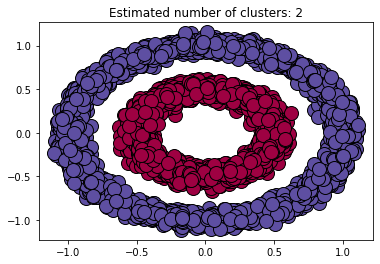

In [14]:
db = DBSCAN(algorithm='auto', eps=0.1, leaf_size = 30,
            metric = 'euclidean', min_samples=3, p = None).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(data, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

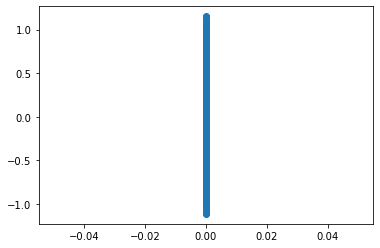

In [15]:
plt.scatter([0] * len(y), y)

In [16]:
def get_cover(domain, interval_len, overlap):
    domain_min = domain[0]
    domain_max = domain[1]
    intervals = []
    upto_low, upto_high = domain_min, domain_min + interval_len
    while True:
        if upto_high >= domain_max:
            intervals.append((upto_low, domain_max))
            break

        intervals.append((round(upto_low, 2), round(upto_high, 2)))
        upto_low += (interval_len - overlap)
        upto_high += (interval_len - overlap)
    
    return intervals

intervals = get_cover(domain = (-1.3, 1.3), interval_len = 0.7, overlap = 0.2)
print(intervals)

[(-1.3, -0.6), (-0.8, -0.1), (-0.3, 0.4), (0.2, 0.9), (0.6999999999999997, 1.3)]


(741, 2) (741,)
(1751, 2) (1751,)
(1844, 2) (1844,)
(1661, 2) (1661,)
(623, 2) (623,)


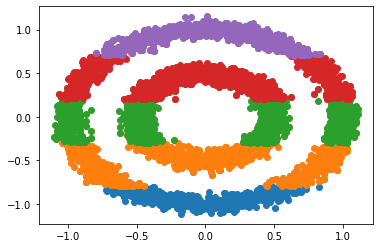

In [17]:
def get_clusters(intervals, data):
    clusters = []
    for (low, high) in intervals:
        to_cluster = list(filter(lambda p : p[1] >= low and p[1] <= high, data))
        if not len(to_cluster):
            continue
        
        to_cluster = np.array(to_cluster)
        x = [i[0] for i in to_cluster]
        y = [i[1] for i in to_cluster]
        plt.scatter(x, y)
        db = DBSCAN(algorithm='auto', eps=0.1, leaf_size = 30,
            metric = 'euclidean', min_samples=10, p = None).fit(to_cluster)
        labels = np.array(db.labels_)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(to_cluster.shape, labels.shape)
        for i in range(0, n_clusters):
            clusters.append(set([tuple(p) for p in to_cluster[labels == i]]))
    
    return clusters

clusters = get_clusters(intervals, data)

In [22]:
from win32api import GetSystemMetrics

def create_graph(file_name):
    max_nodes = max([len(i) for i in clusters])
    g = net.Network(GetSystemMetrics(1), GetSystemMetrics(0), bgcolor="#222222")
    g.add_nodes(nodes = range(0, len(clusters), 1),
                size = [len(x) / len(clusters) for x in clusters],
                title = ["Contains " + str(len(x)) + " elements" for x in clusters],
                label = [' '] * len(clusters),
                color = ['#%02x%02x%02x' % (255, 255 - int(len(i) / max_nodes * 255), 0) for i in clusters])
    for i in range(0, len(clusters)):
        for j in range(i + 1, len(clusters)):
            if clusters[i].intersection(clusters[j]):
                g.add_edge(i, j, color = '#ffdd00')

    g.set_options("""
    var options = {
    "nodes": {
        "shadow": {
        "enabled": true
        }
    },
    "edges": {
        "color": {
        "inherit": true
        },
        "smooth": true
    },
    "physics": {
        "barnesHut": {
        "centralGravity": 0,
        "springLength": 50,
        "springConstant": 0.01,
        "avoidOverlap": 0.5
        },
        "minVelocity": 0.75
    }
    }
    """)
    g.show(file_name)
    return g

graph = create_graph("example.html")

In [65]:
def create_graph(clusters):
    adjacency_matrix = np.zeros([len(clusters)] * 2)
    for i in range(0, len(clusters)):
        for j in range(i + 1, len(clusters)):
            if clusters[i].intersection(clusters[j]):
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1
    
    adjacency_matrix = np.matrix(adjacency_matrix)
    graph = nx.from_numpy_matrix(adjacency_matrix)
    return graph

graph = create_graph(clusters)

In [66]:
def visualize_graph(graph):
    g = net.Network(notebook = True)
    g.from_nx(graph)
    g.show("example.html")

visualize_graph(graph)